In [1]:
import numpy as np
import laspy
import open3d as o3d
import cv2
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.neighbors import KDTree

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def cart2sph(points: np.ndarray) -> np.ndarray:
    """Converts a cartesian coordinate (x, y, z) into a spherical one (radius, theta, phi)."""
    points = points.astype('float32')
    x, y, z = points[:, 0], points[:, 1], points[:, 2]  
    radius = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arctan2(np.sqrt(x*x + y*y), z)
    phi = np.arctan2(y, x)
    
    return np.concatenate([[radius], [theta], [phi]], axis=0).T

def sph2cart(points: np.ndarray) -> np.ndarray:
    """Converts a spherical coordinate (radius, theta, phi) into a cartesian one (x, y, z)."""
    points = points.astype('float32')
    radius, theta, phi = points[:, 0], points[:, 1], points[:, 2]    
    x = radius * np.cos(phi) * np.sin(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(theta)
    
    return np.concatenate([[x], [y], [z]], axis=0).T

In [3]:
intrinsic = np.array(
    [
        [1024, 0, 1024],
        [0, 1024, 1024],
        [0,    0,    1],
    ],
    dtype='float32'
)

extrinsic = np.array(
    [
        [-6.9262244e-02, -9.9737304e-01,  2.1206183e-02,  1.2928122e+05],
        [ 8.4582595e-03, -2.1843584e-02, -9.9972564e-01,  8.3126572e+03],
        [ 9.9756265e-01, -6.9063872e-02,  9.9489763e-03,  8.1891594e+05],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00],
    ],
    dtype='float32'
)

In [4]:
pcd = o3d.geometry.PointCloud()

points = np.load('down_pcd_points.npy')
colors = np.load('down_pcd_colors.npy')

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

camera = np.linalg.inv(extrinsic)[:3, 3]
radius = 50*1000*1000

_, pt_map = pcd.hidden_point_removal(camera, radius)

pcd_sel = pcd.select_by_index(pt_map)
points = np.asarray(pcd_sel.points)

In [5]:
points_cam = cv2.perspectiveTransform(points.reshape(-1, 1, 3), extrinsic).reshape(-1, 3)
points_cam

array([[   5145.23658995,   29362.29688361,  369361.16085169],
       [  40191.17364323,   27406.60058255, -209580.75908499],
       [ -71266.72661482, -116996.19262455, -120881.36839939],
       ...,
       [-985400.81164631, -195832.85834135,  221181.36308113],
       [-985533.97888745, -195690.43424139,  228188.01288498],
       [-985815.28923331, -195613.35060038,  241156.98713096]])

In [6]:
print(len(points_cam))
visibility_mask = points_cam[:, 2] > 0
visible_points_cam = points_cam[visibility_mask]
print(len(visible_points_cam))

13934
5974


In [7]:
image_points, jacobian = cv2.projectPoints(
    visible_points_cam.reshape(-1, 1, 3),
    np.zeros((1, 3), dtype='float32'),
    np.zeros((1, 3), dtype='float32'),
    intrinsic,
    None,
)
image_points = image_points.reshape(-1, 2)
image_points = image_points.astype('uint32')
image_points 

array([[      1038,       1105],
       [       880,        776],
       [       855,        673],
       ...,
       [4294963758,        117],
       [4294963898,        145],
       [4294964135,        193]], dtype=uint32)

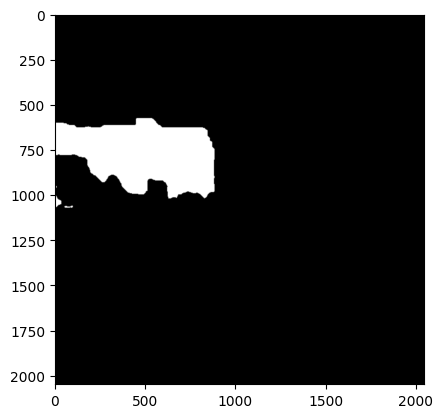

In [8]:
# image_mask = np.zeros((2048, 2048), dtype='uint8')
# cv2.circle(image_mask, (1024, 1500), 500, 255, -1)
image_mask = cv2.imread('../mask_example.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(image_mask, 'gray')
plt.show()

In [9]:
bounding_mask = (image_points[:, 0] < 2048) & (image_points[:, 1] < 2048)
image_points_in_bounds = image_points[bounding_mask]

image_points_in_bounds

array([[1038, 1105],
       [ 880,  776],
       [ 855,  673],
       ...,
       [2035, 1088],
       [2023, 1093],
       [ 427,  988]], dtype=uint32)

In [10]:
target_mask = image_mask[image_points_in_bounds[:, 1], image_points_in_bounds[:, 0]] == 255
target_mask.shape

(3867,)

In [11]:
pt_ids = np.arange(len(points))

common_target_mask = visibility_mask.copy()
common_target_mask[common_target_mask] = bounding_mask
common_target_mask[common_target_mask] = target_mask

# pt_ids = pt_ids[visibility_mask]
# pt_ids = pt_ids[bounding_mask]
# pt_ids = pt_ids[target_mask]

target_pt_ids = pt_ids[common_target_mask]
background_pt_ids = pt_ids[~common_target_mask]
len(target_pt_ids)

1131

In [12]:
target_points = points[target_pt_ids]
background_points = points[background_pt_ids]

target_pcd = o3d.geometry.PointCloud()
background_pcd = o3d.geometry.PointCloud()

target_pcd.points = o3d.utility.Vector3dVector(target_points)
target_pcd.paint_uniform_color([1, 1, 0])

background_pcd.points = o3d.utility.Vector3dVector(background_points)
background_pcd.paint_uniform_color([0, 0, 1])

o3d.visualization.draw_geometries([target_pcd, background_pcd])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Неверный дескриптор. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Требуемая операция преобразования не поддерживается. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Требуемая операция преобразования не поддерживается. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Неверный дескриптор. 
